In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
train_df = pd.read_csv('/content/drive/MyDrive/AI/dataset/JPX_Tokyo_Stock/train_files/stock_prices.csv', parse_dates=True)
valid_df = pd.read_csv('/content/drive/MyDrive/AI/dataset/JPX_Tokyo_Stock/supplemental_files/stock_prices.csv', parse_dates=True)
test_df = pd.read_csv('/content/drive/MyDrive/AI/dataset/JPX_Tokyo_Stock/example_test_files/stock_prices.csv', parse_dates=True)

In [4]:
print(train_df.shape )
print(valid_df.shape )


print("train_df Null Check : {}".format(train_df.isnull().sum()))
print('----------------------------------------------------------')
print("valid_df Null Check : {}".format(valid_df.isnull().sum()))

(2332531, 12)
(112000, 12)
train_df Null Check : RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64
----------------------------------------------------------
valid_df Null Check : RowId                    0
Date                     0
SecuritiesCode           0
Open                   284
High                   284
Low                    284
Close                  284
Volume                   0
AdjustmentFactor         0
ExpectedDividend    111497
SupervisionFlag          0
Target                   0
dtype: int64


In [5]:
df = pd.concat([train_df, valid_df],axis = 0)

del train_df, valid_df

In [6]:
df = df.drop(["ExpectedDividend"],axis=1)
df = df.dropna()

In [7]:
print(df.shape)
df

(2436639, 11)


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...
111995,20220228_9990,2022-02-28,9990,511.0,518.0,509.0,516.0,120600,1.0,False,-0.013592
111996,20220228_9991,2022-02-28,9991,823.0,825.0,814.0,822.0,16200,1.0,False,-0.020581
111997,20220228_9993,2022-02-28,9993,1600.0,1622.0,1600.0,1600.0,4000,1.0,False,0.005762
111998,20220228_9994,2022-02-28,9994,2568.0,2568.0,2540.0,2565.0,9000,1.0,False,-0.002341


In [15]:
## function
def getadvance(x):
    ret = 0
    if x > 0:
        ret = 1
    return(ret)

def get_month(dt):
    x = dt.strftime("%m")
    return(x)

def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.DataFrame.ewm(u, com=period-1, adjust=False).mean() / \
          pd.DataFrame.ewm(d, com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

def rsi_class(x):
    ret = "low"
    if x < 50:
        ret = "low"
    if x > 50:
        ret = "med"
    if x > 70:
        ret = "hi"
    return(ret)

def feture_engineering (data) :
      df_stock = data.copy()
      df_stock = df_stock.sort_values(by = "Date", ascending = False)
      df_stock['pClose'] = df_stock['Close'].shift(-1)
      df_stock['delta'] = df_stock['Close'] - df_stock['pClose']
      df_stock['advance'] = list(map(getadvance, df_stock['delta']))
      df_stock['Date'] = pd.to_datetime(df_stock['Date'], format = "%Y-%m-%d")
      df_stock['Month'] =  list(map(get_month, df_stock['Date']))


      ##RSI
      df_stock = df_stock.sort_values(by = "Date").reset_index()
      df_stock['rsi'] = RSI( df_stock['Close'], 14 )
      df_stock['rsicat'] = list(map(rsi_class, df_stock['rsi']))
      df_stock = df_stock.dropna(axis=0)

      ## SMA and EMA
      df_stock = df_stock.sort_values(by = "Date").reset_index()
      df_s = df_stock[['Date', 'Close']].reset_index(drop = True)
      df_s['20D-EMA'] = df_s['Close'].ewm(span=20,adjust=False).mean()
      df_s['50D-EMA'] = df_s['Close'].ewm(span=50,adjust=False).mean()
      df_s['100D-EMA'] = df_s['Close'].ewm(span=100,adjust=False).mean()
      df_stock = pd.concat([df_stock, df_s['20D-EMA'], df_s['50D-EMA'], df_s['100D-EMA']], axis = 1)
      df_stock = df_stock.drop(['level_0', 'index', 'Date','RowId'],axis= 1)

      return df_stock

# EDA

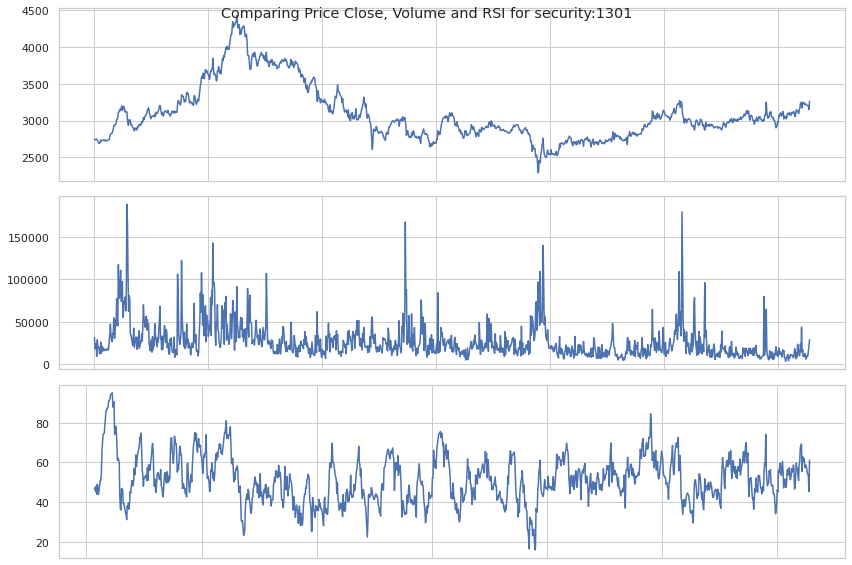

In [16]:
sns.set_style("whitegrid")
SECURITY = 1301
df_stock = df[df['SecuritiesCode'] == SECURITY].reset_index(drop = True)
df_stock = df_stock.sort_values(by = "Date").reset_index()
df_stock['rsi'] = RSI( df_stock['Close'], 14 )
df_stock['rsicat'] = list(map(rsi_class, df_stock['rsi']))



fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (12,8))
fig.subplots_adjust(hspace=0.5)
ax1.plot(df_stock.index, df_stock['Close']);
labels = [item.get_text() for item in ax1.get_xticklabels()]
ax1.set_xticklabels(labels)
ax2.plot(df_stock.index, df_stock['Volume']);
labels = [item.get_text() for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labels)
ax3.plot(df_stock.index, df_stock['rsi']);
labels = [item.get_text() for item in ax3.get_xticklabels()]
ax3.set_xticklabels(labels)
plt.suptitle(f"Comparing Price Close, Volume and RSI for security:{SECURITY}")
plt.tight_layout()

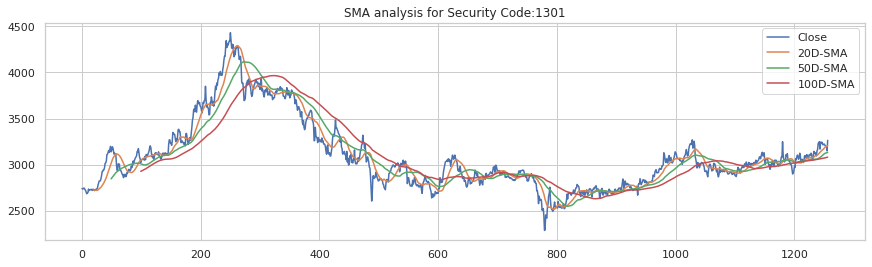

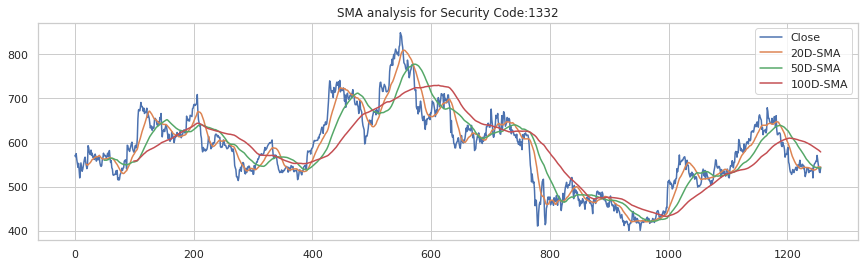

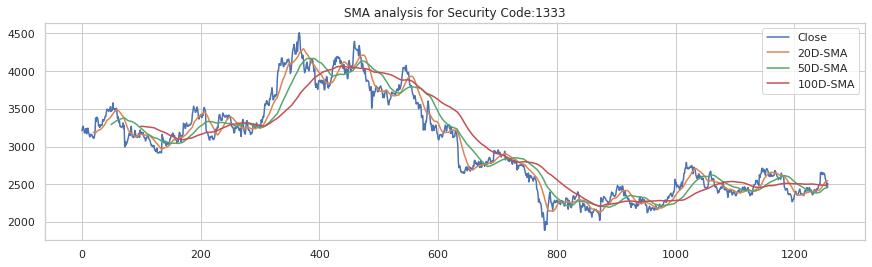

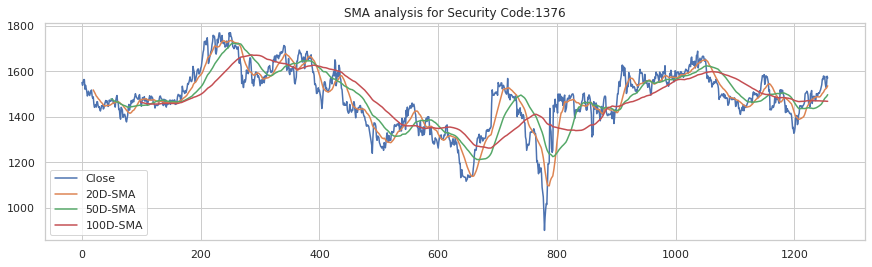

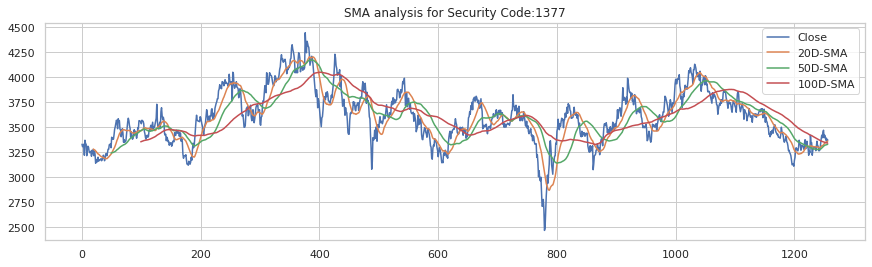

In [19]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(14.7,4)})
# sns.set_style("whitegrid")
seclist = [1301, 1332, 1333, 1376, 1377]
for SECURITY in seclist:
    df_stock = df[df['SecuritiesCode'] == SECURITY].reset_index(drop = True)
    df_stock = df_stock.sort_values(by = "Date").reset_index()
    df_s = df_stock[['Date', 'Close']].reset_index(drop = True)
    df_s['20D-SMA'] = df_s['Close'].rolling(window=20).mean()
    df_s['50D-SMA'] = df_s['Close'].rolling(window=50).mean()
    df_s['100D-SMA'] = df_s['Close'].rolling(window=100).mean()
    df_s.set_index('Date')
    sns.set_style("whitegrid")
    df_s.plot(title = "SMA analysis for Security Code:" + str(SECURITY));

In [11]:
df = feture_engineering(df)
df

,index,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target,pClose,delta,advance,Month,rsi,rsicat
14,13,20170104_1515,2017-01-04,1515,5610.0,5740.0,5560.0,5720.0,25200,1.0,False,-0.026502,1330.0,4390.0,1,01,55.883050,med
15,14,20170104_1518,2017-01-04,1518,1298.0,1340.0,1298.0,1330.0,124300,1.0,False,-0.007559,1190.0,140.0,1,01,47.087505,low
16,15,20170104_1605,2017-01-04,1605,1182.5,1201.0,1180.0,1190.0,5927100,1.0,False,-0.012414,2672.0,-1482.0,0,01,46.834345,low
17,16,20170104_1662,2017-01-04,1662,2629.0,2728.0,2629.0,2672.0,532800,1.0,False,-0.004915,1871.0,801.0,1,01,49.904719,low
18,17,20170104_1663,2017-01-04,1663,1844.0,1871.0,1813.0,1871.0,27400,1.0,False,0.006963,1483.0,388.0,1,01,48.281743,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436634,111995,20220228_9990,2022-02-28,9990,511.0,518.0,509.0,516.0,120600,1.0,False,-0.013592,822.0,-306.0,0,02,47.450244,low
2436635,111996,20220228_9991,2022-02-28,9991,823.0,825.0,814.0,822.0,16200,1.0,False,-0.020581,1600.0,-778.0,0,02,47.606098,low
2436636,111997,20220228_9993,2022-02-28,9993,1600.0,1622.0,1600.0,1600.0,4000,1.0,False,0.005762,1437.0,163.0,1,02,48.028143,low
2436637,111984,20220228_9956,2022-02-28,9956,2172.0,2234.0,2161.0,2225.0,84900,1.0,False,-0.035394,2406.0,-181.0,0,02,48.387821,low
